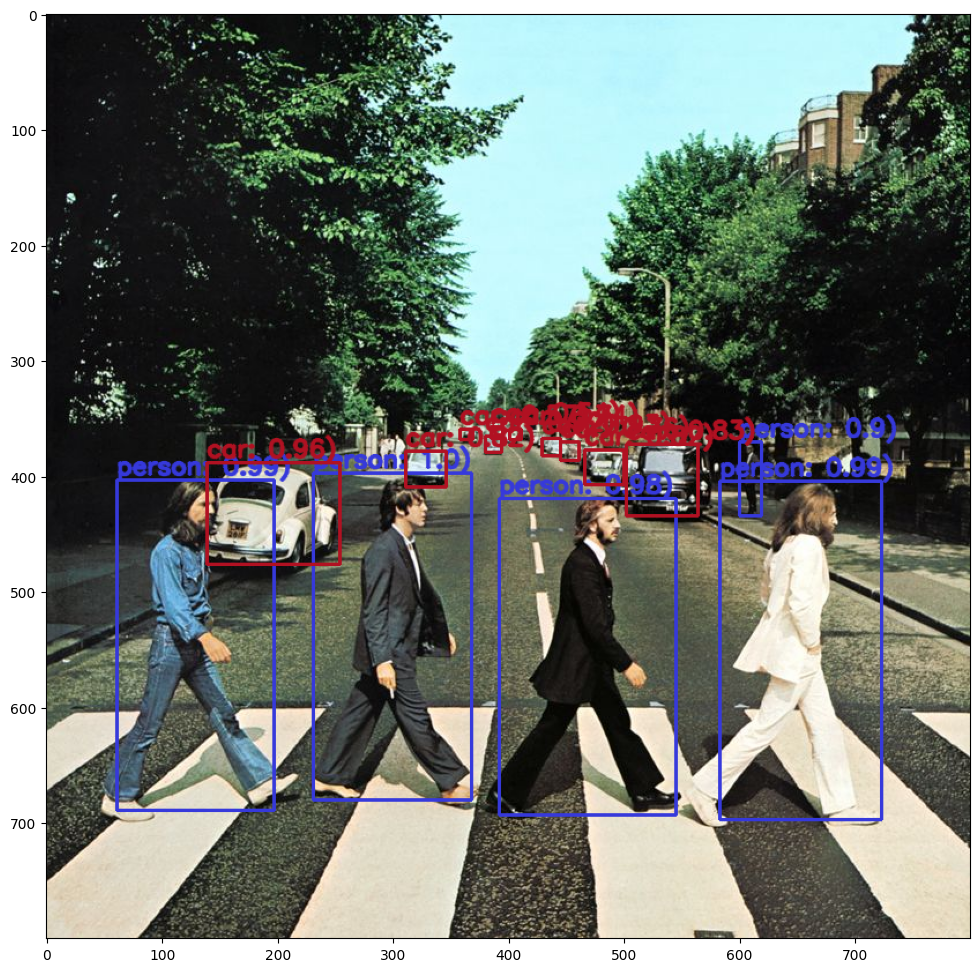

In [1]:


import os
import cv2
import numpy as np 
import matplotlib.pyplot as plt

weights_path = './yolov3.weights'
config_path = './yolov3.cfg'
img = cv2.imread('./bea.jpg')

# weights_path = '여러분의파일경로'
# config_path = '여러분의파일경로'

conf_threshold = 0.5 # confidence score threshold
nms_threshold = 0.4  # nonmaxsuppression threshold 

cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

layer_names = cv_net_yolo.getLayerNames()
outlayer_names = [layer_names[i-1] for i in cv_net_yolo.getUnconnectedOutLayers()]

# img = cv2.imread('이미지경로')

# 해당 모델은 416 x 416이미지를 받음으로 img 크기정해줘야함.
cv_net_yolo.setInput(cv2.dnn.blobFromImage(img, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))

cv_outs = cv_net_yolo.forward(outlayer_names) # layer이름을 넣어주면 그 layer이름에 해당하는 output을 return 하게 됨. 


# rows , cols는 1/255.0 스케일링된 값을 추후 복원시키는 용도로 사용
rows = img.shape[0]
cols = img.shape[1]

# for loop를 돌면서 추출된 값을 담을 리스트 세팅
class_ids = [] 
confidences = []
boxes = []

for _, out in enumerate(cv_outs):
  for _, detection in enumerate(out):
    # detection =>  4(bounding box) + 1(objectness_score) + 80(class confidence)
    class_scores = detection[5:] # 인덱스 5음 부터는 80개의 score 값
    class_id = np.argmax(class_scores) # 80개중에 최대값이 있는 index 값
    confidence = class_scores[class_id] # 최대값 score

    if confidence > conf_threshold:
      # 바운딩 박스 중심 좌표 and 박스 크기
      cx = int(detection[0] * cols) # 0~1 사이로 리사이즈 되어있으니 입력영상에 맞는 좌표계산을 위해 곱해줌.
      cy = int(detection[1] * rows)
      bw = int(detection[2] * cols)
      bh = int(detection[3] * rows)

			# 바운딩 박스를 그리기 위해선 좌상단 점이 필요함(아래는 그 공식)
      left = int(cx - bw / 2) 
      top = int(cy - bh / 2)
						
      class_ids.append(class_id) # class id값 담기
      confidences.append(float(confidence)) # confidence score담기
      boxes.append([left, top, bw, bh]) # 바운딩박스 정보 담기


labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }


# opencv 제공하는 nonmaxsuppression 함수를 통해 가장 확률 높은 바운딩 박스 추출
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold) 

draw_img = img.copy() #그림그리기 위한 도화지

# 같은 라벨별로 같은 컬러를 사용하기 위함/ 사용할때마다 랜덤하게 컬러 설정
colors = np.random.uniform(0, 255, size=(len(labels_to_names_seq),3))

if len(idxs) > 0: # 바운딩박스가 아예 없을 경우를 대비하여 1개 이상일때만 실행하도록 세팅
  for i in idxs:
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
		
		
    caption = f"{labels_to_names_seq[class_ids[i]]}: {confidences[i]:.2})" 
    label = colors[class_ids[i]]
    cv2.rectangle(draw_img, (int(left), int(top), int(width), int(height)), color=label, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label, 2, cv2.LINE_AA)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB) 
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)